# Using Our Pretrained Efficientnetv2-B0 Model Weights for Deepfake Classification

If you are interested in using our pretrained weights with the efficientnetv2-B0 model for deepfake image classification or other similar classification problems, this notebook will walk you through the following processes:
1) **Loading the Model**

2) **Out-of-the-Box Inference**

3) **Transfer Learning**

# Imports

In [44]:
import os
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Resizing
import matplotlib.pyplot as plt

# 1) Loading the Model
You can find and download a zip file with the saved model and its pretrained weights in the github repository for this project [here](https://github.com/annabchox/deepfake-detector/blob/main/Code/PretrainedModel/effnet_deepfake_model.zip).

### Unzip Compressed Model File

In [33]:
!unzip effnet_deepfake_model.zip

Archive:  effnet_deepfake_model.zip
   creating: example_images/
  inflating: example_images/.DS_Store  
  inflating: __MACOSX/example_images/._.DS_Store  
   creating: example_images/Real/
   creating: example_images/Fake/
  inflating: example_images/Real/real_2320.jpg  
  inflating: __MACOSX/example_images/Real/._real_2320.jpg  
  inflating: example_images/Real/real_1213.jpg  
  inflating: __MACOSX/example_images/Real/._real_1213.jpg  
  inflating: example_images/Real/real_263.jpg  
  inflating: __MACOSX/example_images/Real/._real_263.jpg  
  inflating: example_images/Real/real_175.jpg  
  inflating: __MACOSX/example_images/Real/._real_175.jpg  
  inflating: example_images/Real/real_361.jpg  
  inflating: __MACOSX/example_images/Real/._real_361.jpg  
  inflating: example_images/Real/real_179.jpg  
  inflating: __MACOSX/example_images/Real/._real_179.jpg  
  inflating: example_images/Real/real_227.jpg  
  inflating: __MACOSX/example_images/Real/._real_227.jpg  
  inflating: example_im

### Set Model and Weights Paths

In [34]:
model_path = './dffnetv2b0.json'
weights_path = './dffnetv2b0_weights.h5'

### Read The .json File

In [3]:
model_file = open(model_path, 'r')
loaded_model_file = model_file.read()
model_file.close()

### Load Model and Weights

In [29]:
loaded_model = tf.keras.models.model_from_json(loaded_model_file)
loaded_model.load_weights(weights_path)

### Visualize the Model Summary
**Notes About the Model:**
* ***This model comes with a single-neuron dense layer designed for binary classification*** instead of the 1000 neuron output-layer of the Efficientnetv2-b0 designed for use with the imagenet dataset.

* This model also comes with a GlobalMaxPooling layer already built into the the efficientnetv2-b0 layer of the model (hence the two-dimensional output shape of the first layer). There is ***no need to add a GlobalMaxPooling layer*** before the output layer if a new ouput layer is created before transfer learning.

* ***All layers are currently trainable.*** Before beginning transfer learning, it will be important to freeze the weights in the efficientnetv2-b0 layer.

* The type of the first layer (efficientnetv2-b0) is a ```keras.engine.functional.Functional``` object.

    * This Functional object contains the whole of the efficientnet model minus the output layer
    * The summary of the model contained in the funcitonal object by calling .summary() the first layer: ```loaded_model.layer[0].summary()```

#### High Level Model Summary

In [5]:
loaded_model.summary()

Model: "dffnetv2b0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


#### Summary of Efficientnet Model (click arrow to expand)

In [6]:
loaded_model.layers[0].summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  0           ['rescaling_4[0][0]']            
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 32  864         ['normalization[0

# 2) Out-of-the-Box Inference
There are two major steps to using the model to make inferences about a given image:

**a) Image Preprocessing (This will take the majority of the time)**

**b) Making Predictions**

## a) Image Preprocessing
Three image preprocessing steps are necessary before a sample image can be passed to the model for inference.

**i) Convert Image to Array**

**ii) Resize image**

**iii) Reshape image array with ```np.expand_dims()```**

### Get Sample Images
We will create a list of images in the directory of both calsses of our example images and create a simple funciton to select one image at random, returning its path

#### Create List of Sample Images

In [36]:
fake_image_directory = './example_images/Fake/'
real_image_directory = './example_images/Real/'

In [35]:
fake_images = [fake_image_directory + x for x in os.listdir(fake_image_directory)]
real_images = [real_image_directory + x for x in os.listdir(real_image_directory)]

images = fake_images + real_images

#### Get Random Image from Samples

In [8]:
def get_random_image(image_list):
    
    return np.random.choice(images, 1)[0]

In [9]:
sample_image = get_random_image(images)
type(sample_image)

numpy.str_

In [10]:
print(sample_image)

../Models/example_images/Real/real_179.jpg


### 1. Convert Image to Array
We will use the tensorflow methods ```load_img``` and ```img_to_array``` to load an image from its path and convert it to a numpy ndarray

In [11]:
image_array = img_to_array(load_img(sample_image))
type(image_array)

numpy.ndarray

### 1. Resize Image
We will use the keras Resizing layer to make an image resizing layer object that can be called like a funciton on our sample image

#### Set Image Height and Width to match Model Input Shape
The model expects an input shape of (None, 256, 256, 3). The two middle elements of this tuple represent the width and height of the image array.

In [12]:
print(loaded_model.input_shape)

height = loaded_model.input_shape[1]
width = loaded_model.input_shape[2]

(None, 256, 256, 3)


#### Create Resizing Layer

In [13]:
resize_image = Resizing(
    height,
    width,
)

In [14]:
resized_image = resize_image(image_array)
resized_image.shape

TensorShape([256, 256, 3])

### Reshape Array
The shape of the array (now a tensorflow tensor). The resized image is a 3-dimensional tensor, while the model expects a 4-dimensional tensor. We will use ```np.expand_dims()``` to add a fourth dimension to the resized image.

In [15]:
reshaped_image = np.expand_dims(resized_image, axis=0) # axis=0 adds a blank dimension as the first dimension of the image

reshaped_image.shape

(1, 256, 256, 3)

### Put it all Together
We will put all of these preprocessing steps into a single function to prepare a given image for inference. One additional functionality will be added:
* Retrieve the true label of the image, inferred from the image directory

In [16]:
def preprocess_image(image_path, return_label=False):
    
    # convert image to np.ndarray
    image_ndarray = img_to_array(load_img(image_path))
    
    # resize image
    resized_image = resize_image(image_ndarray)
    
    # reshape image tensor
    preprocessed_image = np.expand_dims(resized_image, axis=0)
    
    if return_label:
        
        # retrieve the true label inferred from image path
        true_label = 'Fake' if 'fake' in image_path.lower() else 'Real'
    
        return preprocessed_image, true_label
    else:
        return preprocess_image

In [17]:
test_image, test_label = preprocess_image(sample_image, return_label=True)

In [18]:
print(test_image.shape, test_label)

(1, 256, 256, 3) Real


## b) Make Predictions
**Note:** The model prediction corresponds to the probability that a given image is authentic. A prediction of less than 0.5 indicates a prediction of 'Fake', while a prediction greater than 0.5 indicates a prediction of 'Real'.

### Select and Preprocess Image

In [61]:
my_image = get_random_image(images)
image, label = preprocess_image(my_image, return_label=True)

### Make Prediction

Getting a prediction from the model is as simple as calling: ```loaded_model.predict(image)```. The output is the probability that the given image is authentic.

In [31]:
loaded_model.predict(image)

array([[1.43446055e-08]], dtype=float32)

### Get Prediction Function
We will create a simple function that returns the predicted label to make this a little more useful and use matplotlib to view the image when the model makes a prediction.

In [21]:
def get_prediction(model, img):
    
    return 'Fake' if model.predict(img) <= 0.5 else 'Real'


The model predicted: Real
This image is actually: Real



'Real'

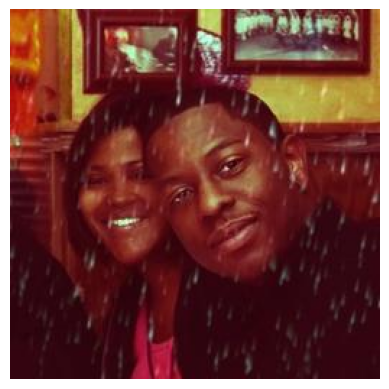

In [62]:
pred = get_prediction(loaded_model, image)

plt.imshow(load_img(my_image))
plt.axis("off")

print(f"""
The model predicted: {pred}
This image is actually: {label}
""")
get_prediction(loaded_model, image)

# 3) Transfer Learning
If you are familiar with transfer learning using the keras API, this process should seem similar with some processes streamlined and one added step to prepare the loaded_model to be added as a pretrained layer in a new model.

The only added step to this process is isolating the first layer of the loaded_model as a ```keras.engine.functional.Functional object```. This is essentially the same object as would be loaded if we created an instance of ```tf.keras.applications.efficientnet_v2.EfficientNetV2B0``` with three differences:

    1. The input shape has been changed to  256 x 256 image sizes from the dataset used to train the model
    2. The weights are initialized as the weights from training on the deepfake dataset
    3. The output layer has been removed (equivalent to passing the include_top=False argument when using the keras API)
    4. GlobalMaxPooling has already been added as the last layer of the efficientnetv2-b0 model to simplify adding fully connected layers and an output layer

### Isolate efficientnetv2-b0 Layer and Freeze Weights

* We can isolate the layer containing the efficientnet model by indexing the first element of ```loaded_model.layers```
* We will freeze the weights just like using a pretrained model from the keras API ```dffnet.trainable  = False```

In [23]:
dffnet = loaded_model.layers[0]
dffnet.trainable = False

In [24]:
type(dffnet)

keras.engine.functional.Functional

### Create a Model with dffnet as a Layer
With the keras Functional object saved in a variable and its layer weights frozen, we can go straight to building a new Sequential model adding the pretrained model as a layer, just as we would when using a pretrained model from the keras API. 

The model below is a very simple implementation to illustrate how to arrange the layers of the model to set it up for transfer learning. A more complex/customized model may be more fitting for your particular use case. We encourage experimentation with more fully connected layers and various regularization methods to further improve performance.

**Note:** *If you want to change the input shape, consult the [Keras Functional API docs](https://www.tensorflow.org/guide/keras/functional) and apply changes to the dffnet layer before adding to the Sequential model.*

In [25]:
# create a new sequential model
transfer_learning_model = Sequential()

# rename model (optional)
transfer_learning_model._name = 'tutorial_dffnet_model'

# resize inputs
transfer_learning_model.add(Resizing(height=256,
                                     width=256,
                                     input_shape=(256, 256, 3) # Change to match your source image sizes
                                    ))

# add pretrained model
transfer_learning_model.add(dffnet)

# add fully connected/output layer(s)
transfer_learning_model.add(Dense(1, activation='sigmoid'))

# compile model
transfer_learning_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics='acc'
)

### View Model Summary
When ```.fit()``` is called on this model, only the 1281 parameters corresponding to the connection between the efficientnetv2-b0 output and the single output neuron will be trainin. The rest of the pretrained weights will be held constant. Even with additional fully connected layers, training will be much faster than retraining the whole model from scratch.

In [26]:
transfer_learning_model.summary()

Model: "tutorial_dffnet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 1,281
Non-trainable params: 5,919,312
_________________________________________________________________


### Fit Model on New Data
We will use our test data to emulate unseen data, creating a train and validation dataset using the ```image_dataset_from_directory()``` keras function. Many of the images in this directory have been subjected to various distortions such as the addition of random gaussian noise, blurring, random contrast adjustment, removal of random pixels, and simulation of rain. Even with a transfer learning model not designed with performance in mind and trained for 5 minutes, we have increased our validation accuracy on the test set from around 0.86 to almost 0.9 over the accuracy that was measure on the same dataset when the pretrained model was evaluated against the same dataset [here](https://github.com/annabchox/deepfake-detector/blob/main/Code/Main/Testing/Best_Models_NN.ipynb).

In [27]:
test_directory = '../../Data/Test/'

train_ds = image_dataset_from_directory(
    directory=test_directory,
    image_size=(256, 256),
    batch_size=64,
    seed=42,
    label_mode='binary',
    labels='inferred',
    validation_split=0.2,
    subset = 'training',
    shuffle=True
)

val_ds = image_dataset_from_directory(
    directory=test_directory,
    image_size=(256, 256),
    batch_size=64,
    seed=42,
    label_mode='binary',
    labels='inferred',
    validation_split=0.2,
    subset = 'validation',
    shuffle=True
)

Found 10910 files belonging to 2 classes.
Using 8728 files for training.
Found 10910 files belonging to 2 classes.
Using 2182 files for validation.


In [28]:
res = transfer_learning_model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5


2023-05-21 00:39:15.652612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


137/137 [==============================] - ETA: 0s - loss: 0.4989 - acc: 0.8236

2023-05-21 00:40:05.796186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


137/137 [==============================] - 65s 455ms/step - loss: 0.4989 - acc: 0.8236 - val_loss: 0.3405 - val_acc: 0.8731
Epoch 2/5
137/137 [==============================] - 61s 445ms/step - loss: 0.2994 - acc: 0.8851 - val_loss: 0.3039 - val_acc: 0.8854
Epoch 3/5
137/137 [==============================] - 59s 433ms/step - loss: 0.2644 - acc: 0.8934 - val_loss: 0.3995 - val_acc: 0.8676
Epoch 4/5
137/137 [==============================] - 61s 442ms/step - loss: 0.2613 - acc: 0.8983 - val_loss: 0.2776 - val_acc: 0.8973
Epoch 5/5
137/137 [==============================] - 62s 449ms/step - loss: 0.2312 - acc: 0.9085 - val_loss: 0.2732 - val_acc: 0.8978


# Use Your New Model for Inference!

Once the model has been retrained on your data, you can start using it for inference just like we did with the pretrained model

### Make a Prediction


The model predicted: Fake
This image is actually: Fake



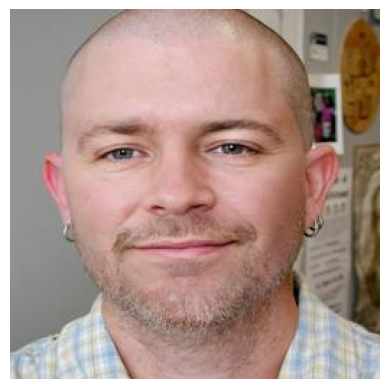

In [57]:
my_image = get_random_image(images)
image, label = preprocess_image(my_image, return_label=True)
pred = get_prediction(transfer_learning_model, image)

plt.imshow(load_img(my_image))
plt.axis("off")

print(f"""
The model predicted: {pred}
This image is actually: {label}
""")